# Импорты

Импорт всех необходимых библиотек

In [2]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [6]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [7]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [8]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

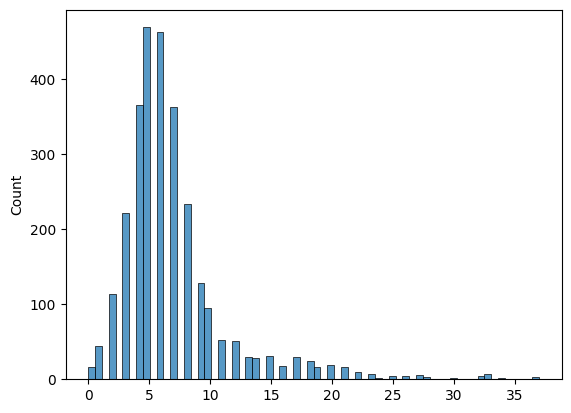

In [9]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [10]:
df = df.drop(df[df['bmi']>80].index)

In [11]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

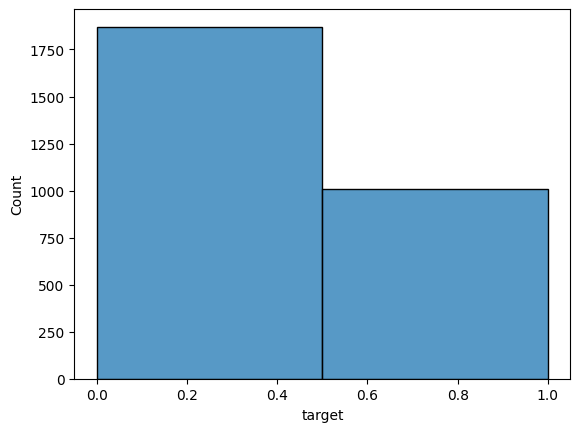

In [12]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [13]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

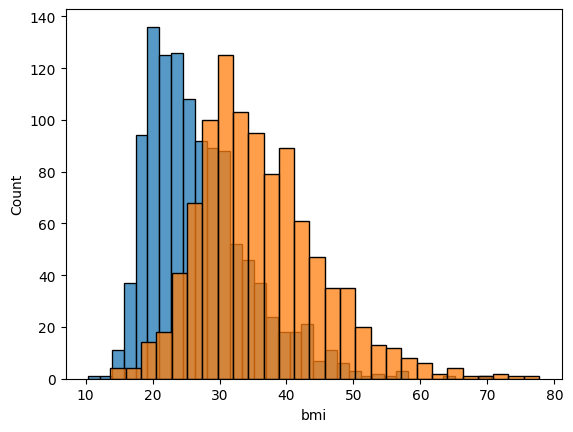

In [14]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [15]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
1218,NaN,NaN,NaN,411.09,11.90,822.96,13.91,580.76,748.84,3.04,6.32,30.58,1.49,1.24,5.55,7.57,847.72,5.30,0.62,34.23,395.25,0.40,0.40,15.10,1.07,34.63,5.76,87.17,3.46,266.33,0.29,0.65,1.90,0.48,82.16,0.96,135.88,24.80,NaN,1.75,498.35,0.43,NaN,0.61,5.39,3.46,0.01,0.94,21.41,0.96,1.04,0.26,4.83,NaN,0.98,1.54,NaN,1.79,4.32,1.93,40.38,4.48,1.02,0.38,6.72,15.13,38.73,41.84,4.81,2.87,1,0,0,1,31.195095,0
1981,14.5,48.5,26.9,496.08,38.29,2658.22,157.45,3278.18,1878.30,52.85,22.20,153.24,5.32,4.36,27.75,29.93,6528.82,70.54,2.33,123.39,1236.77,0.12,0.10,249.16,3.84,414.48,20.06,634.02,29.11,1075.90,3.21,3.23,11.26,3.19,539.94,5.25,230.09,0.00,0.02,6.53,2302.23,3.45,NaN,2.10,31.40,14.52,0.14,3.33,226.17,3.54,1.25,1.02,23.14,NaN,3.68,27.86,58.0,6.40,36.71,49.29,24.85,39.01,6.49,2.85,35.18,66.60,155.55,213.08,35.16,13.90,1,0,1,0,28.479886,0
1824,NaN,NaN,NaN,413.38,20.73,2127.24,33.44,1156.82,1012.35,8.23,13.94,59.27,3.38,2.77,12.20,9.89,1956.14,5.42,1.69,49.23,439.55,3.01,0.40,15.98,2.49,104.84,12.52,171.89,2.81,1595.26,0.83,1.02,2.82,1.47,183.10,11.20,111.43,586.00,0.02,4.34,890.46,1.79,NaN,1.36,11.43,3.61,0.00,2.06,46.25,2.38,0.20,0.61,5.13,NaN,2.30,1.04,16.0,4.13,14.79,1.43,77.89,4.15,2.16,0.88,4.12,8.58,66.24,53.81,3.01,10.98,0,1,1,0,26.196187,0
2367,NaN,45.3,NaN,180.22,19.07,2594.59,76.82,2024.74,1198.40,41.16,28.05,73.14,3.73,2.63,21.02,22.34,4042.66,36.39,1.37,84.20,773.75,2.66,NaN,91.25,2.24,259.31,26.74,480.19,16.21,1087.16,1.93,2.07,5.49,2.11,494.73,2.96,170.05,66.28,0.17,3.97,1344.95,1.94,NaN,0.98,21.23,16.62,0.07,1.73,221.81,2.05,1.71,0.62,27.53,0.01,2.42,6.51,100.0,3.83,19.38,8.75,124.45,19.50,6.41,2.05,18.93,41.73,77.88,171.25,13.42,9.24,1,0,0,1,31.826100,0
2632,NaN,NaN,NaN,740.81,84.84,5031.82,160.28,3868.62,2404.33,35.59,29.55,148.76,4.18,3.51,30.67,26.85,5151.82,98.37,2.03,193.48,1978.98,5.48,0.60,75.24,3.02,384.05,25.15,569.79,10.30,2125.04,2.29,3.15,4.91,2.23,435.20,7.30,264.67,236.00,0.02,5.17,2562.12,2.01,0.09,1.67,23.58,8.79,0.01,2.67,190.98,3.03,1.45,0.81,23.71,NaN,2.88,4.91,120.0,5.03,29.45,8.13,168.20,10.54,4.12,1.51,8.22,14.97,90.59,88.17,7.09,13.69,1,0,0,1,30.668905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,NaN,NaN,NaN,496.95,30.32,2208.21,66.86,2081.03,1282.02,17.27,18.04,78.74,4.69,3.75,14.93,25.93,2716.58,44.13,2.34,109.89,574.84,9.59,0.40,33.88,3.39,193.79,16.51,298.78,6.32,549.95,1.52,1.60,4.08,1.68,285.64,3.79,238.22,87.00,0.08,5.77,1187.87,1.25,0.01,1.86,16.33,9.28,0.03,2.86,92.00,3.10,1.37,0.87,17.67,46.63,3.14,2.81,20.0,5.71,21.59,143.12,85.58,10.50,6.28,1.10,14.32,30.72,122.38,118.95,10.30,12.13,1,0,1,0,27.180900,1
37,NaN,NaN,NaN,73.42,2.91,65.68,NaN,167.67,49.03,NaN,3.30,16.08,1.56,1.16,0.87,1.27,263.23,NaN,0.75,8.08,11.90,NaN,NaN,NaN,1.08,NaN,2.87,18.39,NaN,7.33,0.06,0.18,0.64,0.29,6.80,1.23,29.45,NaN,NaN,1.81,152.97,0.09,NaN,0.62,1.91,1.21,NaN,0.88,NaN,1.01,0.03,0.26,0.01,NaN,0.91,NaN,NaN,1.72,3.55,

In [16]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [17]:
column_names = x_train.columns

In [18]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [19]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [20]:
x_train = x_train.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,-0.290079,-0.259669,-0.279904,0.498584,0.036541,-0.199037,0.249204,-0.283632,-0.207916,-0.033051,-0.077803,-0.008948,0.218739,0.347272,0.133640,-0.109551,-0.120018,-0.038661,NaN,-0.145540,-0.083774,-0.030863,0.221577,-0.280180,0.046259,1.033037,-0.237079,-0.164709,-0.197078,0.134330,0.289791,-0.274852,-0.615608,-0.505000,-0.696400,NaN,-0.103838,-0.225180,-0.192770,-0.244414,-0.057352,0.379930,0.123225,-0.229577,-0.066291,0.525675,-0.076231,-0.237376,-0.120553,0.169990,NaN,-0.105382,-0.075260,-0.755559,-0.071693,-0.026298,-0.452638,-0.313928,0.194368,-0.488041,0.093932,1.304479,1.519531,0.019826,-0.092022,1.187506,-0.109250,1.083179,-0.284600,2.205627,-0.690359,-1.100466
1,NaN,-1.702525,NaN,0.561740,0.583646,0.334872,0.346561,0.727042,0.989111,0.091806,0.490221,0.893085,1.480421,1.251297,0.562333,0.304149,0.448582,1.437303,1.186587,0.607783,0.239546,-0.300382,NaN,-0.292838,1.355623,0.568522,0.434143,0.795671,-0.519660,-0.207786,0.115720,0.623614,0.666095,0.842156,-0.158029,0.355414,-0.587015,-0.696231,0.838644,1.263666,0.695352,1.410558,-0.215709,1.379666,0.486617,0.713920,-0.229577,1.263334,-0.613097,1.285631,-0.284764,1.142545,0.460934,0.851475,1.214425,-0.230497,NaN,1.269648,0.861945,1.272597,1.698708,-0.475833,0.940339,0.333581,-0.596787,-0.631351,1.447885,-0.666594,-0.632056,0.498765,-0.923208,3.513709,2.205627,-0.690359,-1.084321
2,NaN,-0.017454,NaN,0.640244,1.146690,0.297285,1.918616,1.715627,1.745179,1.279716,2.558041,1.373429,1.873404,1.242858,1.082700,1.496907,1.418443,0.145350,1.329807,1.761459,1.703205,-0.325128,2.409593,0.095431,1.221755,1.610494,2.694260,2.121128,1.835540,0.257916,0.915971,1.898617,0.850839,0.885198,1.441572,0.115705,0.968150,0.066562,0.172349,1.296953,1.660570,0.362468,-0.206141,0.863372,1.251864,3.216076,1.092787,1.024683,0.891779,1.178519,0.035800,1.288991,2.707797,NaN,1.584176,0.171688,-0.452486,1.375921,1.289467,-0.224189,-0.151403,0.666736,1.045915,1.846364,1.255069,1.836196,1.094212,1.474272,1.732542,1.273440,1.083179,-0.284600,-0.453386,1.448521,0.633870
3,NaN,NaN,NaN,2.022612,0.904363,0.524357,-0.696136,1.003438,0.095550,-0.177595,1.792084,2.684748,6.027331,5.593023,0.447029,0.930818,0.766555,0.131358,5.719491,1.320205,0.150040,NaN,NaN,-0.343349,6.021866,-0.283132,1.615347,0.283868,-0.779366,-0.568986,0.553464,1.063270,2.635871,2.477731,0.219244,0.483394,0.256225,1.584368,NaN,5.543705,1.557577,1.404319,NaN,6.215618,0.811946,1.847191,NaN,5.769283,-0.536022,5.758866,-0.156538,5.188120,-0.605664,1.794064,5.173843,-0.266287,NaN,5.658444,2.909444,0.840616,-0.294375,-0.554405,1.468219,0.820368,-0.798964,-0.804078,5.502253,-0.950797,-0.722896,4.097438,-0.923208,-0.284600,-0.453386,-0.690359,NaN
4,NaN,0.811708,NaN,0.027651,0.101138,0.275604,-0.248443,0.330318,1.058142,0.296296,0.327554,0.163463,0.389162,0.390546,0.271826,0.310604,0.178156,0.060031,0.377396,0.092657,-0.051423,1.238326,NaN,0.084533,0.332492,0.162099,0.328994,0.304850,-0.237184,0.238529,0.238836,0.198613,0.209227,0.146319,0.673824,0.172585,0.276452,0.765253,-0.015580,0.367715,0.173810,0.237695,-0.244414,0.304054,0.322636,0.073447,-0.229577,0.359871,0.075638,0.362421,-0.061763,0.410314,0.3219

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков get_feature_importance из CatBoost

In [21]:
model = CatBoostClassifier(random_seed=42)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)
model.get_feature_importance(catboost.Pool(x_train))

Learning rate set to 0.037982
0:	learn: 0.6691234	test: 0.6881127	best: 0.6881127 (0)	total: 57.4ms	remaining: 57.3s
200:	learn: 0.2316205	test: 0.6609850	best: 0.6522260 (118)	total: 903ms	remaining: 3.59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6522259973
bestIteration = 118

Shrink model to first 119 iterations.


array([8.23629649e-01, 4.32687000e+00, 6.93233142e-01, 1.30642539e+00,
       3.41788805e-01, 7.80242814e-01, 7.47947161e-01, 3.09682762e-01,
       9.32326739e-01, 4.48148717e-01, 7.52093052e-01, 5.63798115e-01,
       1.91809472e-02, 4.44567153e-01, 7.20030066e-01, 1.20897697e+00,
       4.87949099e-01, 4.63553743e-01, 1.36836924e+00, 4.21572873e-01,
       6.96179066e-01, 7.48902184e-01, 2.37025061e-01, 8.97911463e-01,
       5.33058425e-01, 8.37995068e-01, 4.31269107e-01, 1.37736435e-01,
       1.25971968e+00, 4.31660072e-01, 5.63173860e-01, 6.23741559e-01,
       4.60052524e-01, 3.45139717e-01, 6.83710252e-01, 6.30739715e-01,
       1.49412787e+00, 2.47744337e+00, 1.43123467e+00, 6.49766610e-01,
       3.36212672e-01, 8.55321078e-01, 2.55608686e+00, 1.14455332e+00,
       1.82338886e-01, 1.13842854e+00, 2.47359166e+00, 4.83894737e-01,
       1.05028234e+00, 8.99322638e-01, 1.09883882e+00, 2.72567374e-01,
       7.09704391e-01, 6.46716684e-01, 3.64601147e-01, 6.22439889e-01,
      

<BarContainer object of 75 artists>

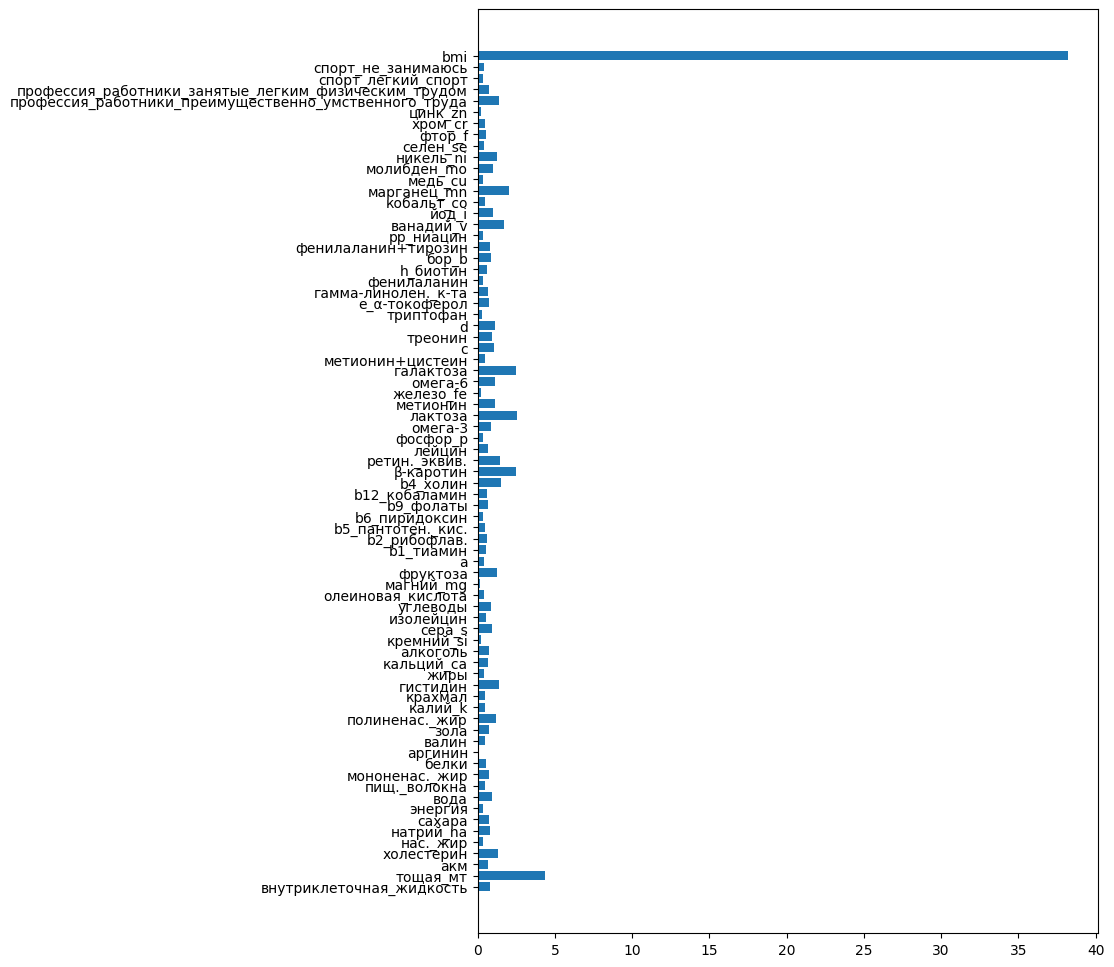

In [22]:
plt.figure(figsize=(8,12))
plt.barh(column_names, model.get_feature_importance(catboost.Pool(x_train)))

In [23]:
import heapq
importances = model.get_feature_importance(catboost.Pool(x_train))
max_imp = heapq.nlargest(9, importances)

features_selected_indx = np.where(np.isin(importances, max_imp))[0]
features_selected_indx

array([ 1, 36, 37, 38, 42, 46, 59, 62, 74])

In [24]:
features_selected = df.columns[features_selected_indx]
features_selected

Index(['тощая_мт', 'b4_холин', 'β-каротин', 'ретин._эквив.', 'лактоза',
       'галактоза', 'ванадий_v', 'марганец_mn', 'bmi'],
      dtype='object')

Убираем из признаков ИМТ

In [25]:
#features_selected = features_selected[:-1]
features_selected

Index(['тощая_мт', 'b4_холин', 'β-каротин', 'ретин._эквив.', 'лактоза',
       'галактоза', 'ванадий_v', 'марганец_mn', 'bmi'],
      dtype='object')

## Финальный набор признаков

In [26]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_val_selected = x_val.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

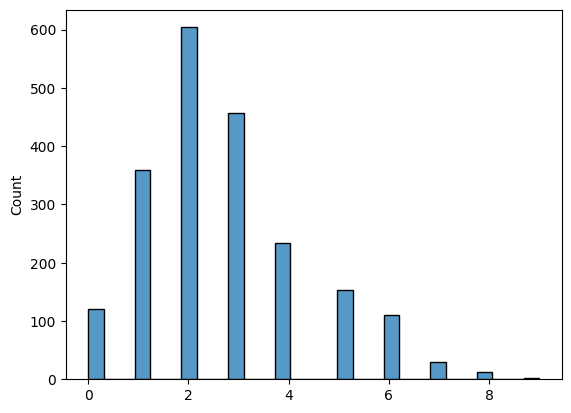

In [27]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

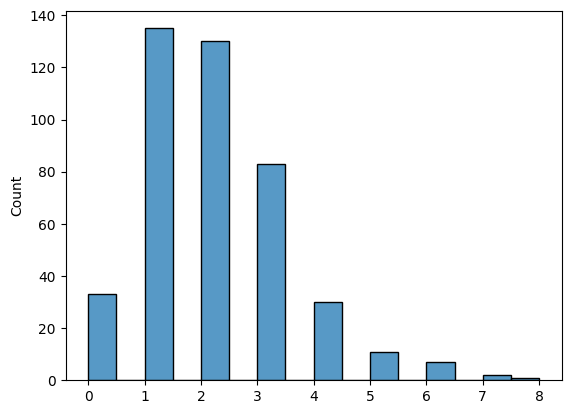

In [28]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [29]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_val_imp = it_imp.transform(x_val)
x_test_imp = it_imp.transform(x_test)

In [30]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [31]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-24 12:14:12,993] A new study created in memory with name: no-name-2171c4f0-8888-467b-90d7-fe252c5507a5
[I 2024-11-24 12:14:19,385] Trial 0 finished with value: 0.4 and parameters: {'max_depth': 8, 'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4.
[I 2024-11-24 12:14:22,256] Trial 1 finished with value: 0.3249097472924187 and parameters: {'max_depth': 4, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4.
[I 2024-11-24 12:14:28,695] Trial 2 finished with value: 0.4131147540983607 and parameters: {'max_depth': 8, 'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.4131147540983607.
[I 2024-11-24 12:14:37,804] Trial 3 finished with value: 0.4052287581699347 and parameters: {'max_depth': 10, 'n_estimators': 900, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.4131147540983607.
[I 2024-11-24 12:14:41,01

In [32]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best ROC-AUC score: 0.4253968253968254


In [33]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=9, n_estimators=800)

Метрики, получаемые из кросс-валидации

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([6.27596617, 6.27588272, 6.18524289, 6.23062444, 6.22875309]),
 'score_time': array([0.17273903, 0.16879535, 0.16853142, 0.16729116, 0.18139172]),
 'test_accuracy': array([0.77697842, 0.80815348, 0.83413462, 0.81490385, 0.80528846]),
 'test_precision_macro': array([0.74924658, 0.78604156, 0.83386412, 0.80004699, 0.78076923]),
 'test_recall_macro': array([0.73628643, 0.77240143, 0.77975303, 0.76727363, 0.77310781]),
 'test_f1_macro': array([0.74175784, 0.77830941, 0.79746978, 0.77934379, 0.77663319]),
 'test_roc_auc': array([0.85198172, 0.87317542, 0.881328  , 0.87175261, 0.87334851])}

In [35]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [36]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [37]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [38]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.88      0.68       216
           1       0.70      0.30      0.42       216

    accuracy                           0.59       432
   macro avg       0.63      0.59      0.55       432
weighted avg       0.63      0.59      0.55       432

F2-score:  0.33507853403141363


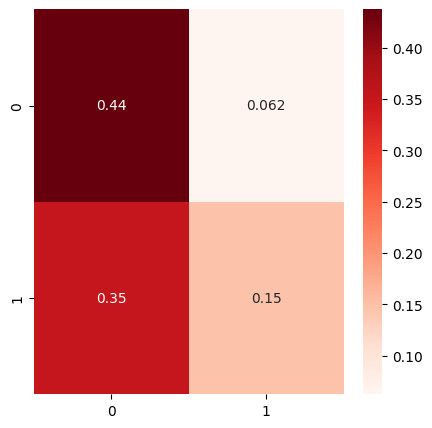

In [39]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [40]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [41]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-24 12:17:34,113] A new study created in memory with name: no-name-84ecdcfd-b802-4b54-9973-c9f2fb676533


[12:17:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:35,257] Trial 0 finished with value: 0.583941605839416 and parameters: {'max_depth': 7, 'n_estimators': 500}. Best is trial 0 with value: 0.583941605839416.


[12:17:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:36,971] Trial 1 finished with value: 0.5770171149144254 and parameters: {'max_depth': 9, 'n_estimators': 600}. Best is trial 0 with value: 0.583941605839416.


[12:17:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:38,120] Trial 2 finished with value: 0.6105769230769229 and parameters: {'max_depth': 6, 'n_estimators': 700}. Best is trial 2 with value: 0.6105769230769229.


[12:17:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:38,899] Trial 3 finished with value: 0.6113744075829385 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 3 with value: 0.6113744075829385.


[12:17:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:38,992] Trial 4 finished with value: 0.6288032454361054 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 4 with value: 0.6288032454361054.


[12:17:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:40,321] Trial 5 finished with value: 0.6072289156626506 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 4 with value: 0.6288032454361054.


[12:17:40] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:40,592] Trial 6 finished with value: 0.6037735849056604 and parameters: {'max_depth': 5, 'n_estimators': 200}. Best is trial 4 with value: 0.6288032454361054.


[12:17:40] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:41,457] Trial 7 finished with value: 0.6191536748329621 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 4 with value: 0.6288032454361054.


[12:17:41] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:42,244] Trial 8 finished with value: 0.6113744075829385 and parameters: {'max_depth': 5, 'n_estimators': 600}. Best is trial 4 with value: 0.6288032454361054.


[12:17:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:42,390] Trial 9 finished with value: 0.5953488372093022 and parameters: {'max_depth': 5, 'n_estimators': 100}. Best is trial 4 with value: 0.6288032454361054.


[12:17:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:42,631] Trial 10 finished with value: 0.6175869120654396 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 4 with value: 0.6288032454361054.


[12:17:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:43,371] Trial 11 finished with value: 0.6229508196721312 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 4 with value: 0.6288032454361054.


[12:17:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:43,677] Trial 12 finished with value: 0.6188524590163935 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 4 with value: 0.6288032454361054.


[12:17:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:46,884] Trial 13 finished with value: 0.5714285714285714 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 4 with value: 0.6288032454361054.


[12:17:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:47,620] Trial 14 finished with value: 0.6229508196721312 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 4 with value: 0.6288032454361054.


[12:17:47] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:47,738] Trial 15 finished with value: 0.6184210526315789 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 4 with value: 0.6288032454361054.


[12:17:47] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:48,728] Trial 16 finished with value: 0.5812807881773399 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 4 with value: 0.6288032454361054.


[12:17:48] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:49,529] Trial 17 finished with value: 0.6191536748329621 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 4 with value: 0.6288032454361054.


[12:17:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:51,367] Trial 18 finished with value: 0.5770171149144254 and parameters: {'max_depth': 7, 'n_estimators': 900}. Best is trial 4 with value: 0.6288032454361054.


[12:17:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:51,603] Trial 19 finished with value: 0.6175869120654396 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 4 with value: 0.6288032454361054.


[12:17:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:52,118] Trial 20 finished with value: 0.6146993318485523 and parameters: {'max_depth': 4, 'n_estimators': 500}. Best is trial 4 with value: 0.6288032454361054.


[12:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:52,858] Trial 21 finished with value: 0.6229508196721312 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 4 with value: 0.6288032454361054.


[12:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:53,523] Trial 22 finished with value: 0.6229508196721312 and parameters: {'max_depth': 3, 'n_estimators': 900}. Best is trial 4 with value: 0.6288032454361054.


[12:17:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:54,524] Trial 23 finished with value: 0.6238938053097345 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 4 with value: 0.6288032454361054.


[12:17:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:55,426] Trial 24 finished with value: 0.6160714285714285 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 4 with value: 0.6288032454361054.


[12:17:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:56,129] Trial 25 finished with value: 0.6191536748329621 and parameters: {'max_depth': 4, 'n_estimators': 700}. Best is trial 4 with value: 0.6288032454361054.


[12:17:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:57,621] Trial 26 finished with value: 0.6139088729016786 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 4 with value: 0.6288032454361054.


[12:17:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:57,788] Trial 27 finished with value: 0.6257668711656442 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 4 with value: 0.6288032454361054.


[12:17:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:58,096] Trial 28 finished with value: 0.6037735849056604 and parameters: {'max_depth': 5, 'n_estimators': 200}. Best is trial 4 with value: 0.6288032454361054.


[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:17:58,314] Trial 29 finished with value: 0.6057906458797327 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 4 with value: 0.6288032454361054.


In [42]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best f1 score: 0.6288032454361054


In [43]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [44]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:17:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [45]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.61      0.44      0.51       216
           1       0.56      0.72      0.63       216

    accuracy                           0.58       432
   macro avg       0.58      0.58      0.57       432
weighted avg       0.58      0.58      0.57       432

F2-score:  0.6792287467134093


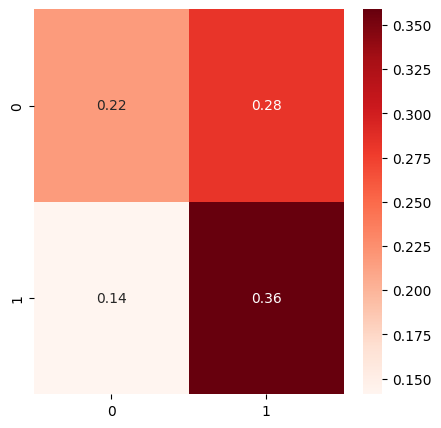

In [46]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [47]:
model = CatBoostClassifier(random_seed=42)

In [48]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037982
0:	learn: 0.6655030	test: 0.6912001	best: 0.6912001 (0)	total: 1.77ms	remaining: 1.77s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6654295915
bestIteration = 58

Shrink model to first 59 iterations.


In [49]:
f1_score(y_test, model.predict(x_test_selected))

0.6045454545454545

In [50]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 9.39963993,  4.62897531,  9.97730185,  3.29188677,  5.17005644,
        5.06596352,  6.54308318,  8.87380738, 47.04928562])

In [51]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [52]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-24 12:17:59,387] A new study created in memory with name: no-name-bd1a0817-76b9-40b7-8f31-f7535c6b7864
[I 2024-11-24 12:18:00,119] Trial 0 finished with value: 0.48753462603878117 and parameters: {'learning_rate': 0.002317324519222854, 'depth': 6, 'subsample': 0.4961846136018578, 'colsample_bylevel': 0.13501566536821785, 'min_data_in_leaf': 22, 'random_strength': 0.8593640571868495}. Best is trial 0 with value: 0.48753462603878117.
[I 2024-11-24 12:18:00,891] Trial 1 finished with value: 0.5925925925925926 and parameters: {'learning_rate': 0.004827797777720349, 'depth': 4, 'subsample': 0.7256299824374545, 'colsample_bylevel': 0.16955021707518025, 'min_data_in_leaf': 83, 'random_strength': 0.6502560472097949}. Best is trial 1 with value: 0.5925925925925926.
[I 2024-11-24 12:18:01,767] Trial 2 finished with value: 0.5721271393643031 and parameters: {'learning_rate': 0.033396553383747925, 'depth': 3, 'subsample': 0.7566951581490273, 'colsample_bylevel': 0.7640862633122658, 'min

In [53]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.001039830225213189, 'depth': 5, 'subsample': 0.7094190013740438, 'colsample_bylevel': 0.6994986131049562, 'min_data_in_leaf': 9, 'random_strength': 1.022816383244714}
Best f1 score: 0.6304347826086956


In [54]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6924842	total: 1.21ms	remaining: 1.21s
1:	learn: 0.6916970	total: 2.43ms	remaining: 1.21s
2:	learn: 0.6909267	total: 3.5ms	remaining: 1.16s
3:	learn: 0.6902947	total: 4.62ms	remaining: 1.15s
4:	learn: 0.6895899	total: 5.69ms	remaining: 1.13s
5:	learn: 0.6888308	total: 6.76ms	remaining: 1.12s
6:	learn: 0.6881336	total: 7.77ms	remaining: 1.1s
7:	learn: 0.6874859	total: 8.84ms	remaining: 1.1s
8:	learn: 0.6867549	total: 9.9ms	remaining: 1.09s
9:	learn: 0.6860576	total: 10.9ms	remaining: 1.08s
10:	learn: 0.6853878	total: 12ms	remaining: 1.07s
11:	learn: 0.6846856	total: 13ms	remaining: 1.07s
12:	learn: 0.6840017	total: 14ms	remaining: 1.06s
13:	learn: 0.6833219	total: 15ms	remaining: 1.06s
14:	learn: 0.6826758	total: 16ms	remaining: 1.05s
15:	learn: 0.6820032	total: 17.1ms	remaining: 1.05s
16:	learn: 0.6812270	total: 18.1ms	remaining: 1.05s
17:	learn: 0.6805627	total: 19.1ms	remaining: 1.04s
18:	learn: 0.6798464	total: 20.2ms	remaining: 1.04s
19:	learn: 0.6791657	total: 21.3ms	r

In [55]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6924447	total: 1.1ms	remaining: 1.1s
1:	learn: 0.6916595	total: 2.25ms	remaining: 1.12s
2:	learn: 0.6908519	total: 3.24ms	remaining: 1.08s
3:	learn: 0.6901379	total: 4.24ms	remaining: 1.05s
4:	learn: 0.6895036	total: 5.22ms	remaining: 1.04s
5:	learn: 0.6887678	total: 6.22ms	remaining: 1.03s
6:	learn: 0.6880387	total: 7.16ms	remaining: 1.01s
7:	learn: 0.6872623	total: 7.99ms	remaining: 990ms
8:	learn: 0.6864555	total: 8.73ms	remaining: 962ms
9:	learn: 0.6857256	total: 9.47ms	remaining: 938ms
10:	learn: 0.6850038	total: 10.2ms	remaining: 916ms
11:	learn: 0.6841923	total: 10.9ms	remaining: 898ms
12:	learn: 0.6834975	total: 11.7ms	remaining: 888ms
13:	learn: 0.6828113	total: 12.6ms	remaining: 887ms
14:	learn: 0.6821166	total: 13.5ms	remaining: 888ms
15:	learn: 0.6814360	total: 14.5ms	remaining: 890ms
16:	learn: 0.6806257	total: 15.4ms	remaining: 891ms
17:	learn: 0.6799632	total: 16.3ms	remaining: 891ms
18:	learn: 0.6792289	total: 17.3ms	remaining: 895ms
19:	learn: 0.6785527	tot

{'fit_time': array([1.03657246, 1.04510427, 1.07459974, 1.08505535, 1.08548427]),
 'score_time': array([0.00771523, 0.00874615, 0.00777578, 0.00774288, 0.00790834]),
 'test_accuracy': array([0.80815348, 0.82733813, 0.83653846, 0.82451923, 0.82692308]),
 'test_precision_macro': array([0.78292888, 0.80386567, 0.81329501, 0.80032978, 0.80297721]),
 'test_recall_macro': array([0.7888811 , 0.81420446, 0.82798315, 0.80973498, 0.81895717]),
 'test_f1_macro': array([0.78569226, 0.80843244, 0.81944444, 0.80454022, 0.8094414 ]),
 'test_roc_auc': array([0.86483819, 0.89384967, 0.9103681 , 0.89749627, 0.88671742])}

In [56]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       216
           1       0.59      0.67      0.63       216

    accuracy                           0.60       432
   macro avg       0.61      0.60      0.60       432
weighted avg       0.61      0.60      0.60       432

F2-score:  0.653742110009017


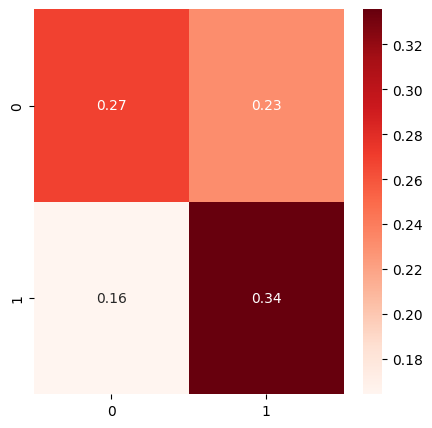

In [57]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [58]:
model = XGBClassifier()

In [59]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [60]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [61]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-24 12:18:53,728] A new study created in memory with name: no-name-11235f46-1b17-4f73-9bc2-e9c6dd0f2dbc


[12:18:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:54,490] Trial 0 finished with value: 0.5803357314148683 and parameters: {'learning_rate': 0.01313733959849085, 'max_depth': 325, 'n_estimators': 200, 'subsample': 0.922248984640094, 'colsample_bylevel': 0.8235024899617636, 'gamma': 1.4587867462205708}. Best is trial 0 with value: 0.5803357314148683.


[12:18:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:55,959] Trial 1 finished with value: 0.5851318944844125 and parameters: {'learning_rate': 0.001245309005830325, 'max_depth': 440, 'n_estimators': 500, 'subsample': 0.7502632976142423, 'colsample_bylevel': 0.8345243333813119, 'gamma': 1.0856515674999394}. Best is trial 1 with value: 0.5851318944844125.


[12:18:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:56,520] Trial 2 finished with value: 0.5515587529976019 and parameters: {'learning_rate': 0.04496271675672189, 'max_depth': 388, 'n_estimators': 300, 'subsample': 0.4516764129918012, 'colsample_bylevel': 0.28712199680272116, 'gamma': 0.10034285169470912}. Best is trial 1 with value: 0.5851318944844125.


[12:18:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:57,176] Trial 3 finished with value: 0.5721271393643031 and parameters: {'learning_rate': 0.01592765425317779, 'max_depth': 118, 'n_estimators': 1000, 'subsample': 0.0668505788341207, 'colsample_bylevel': 0.3568660957197138, 'gamma': 1.9502400715924837}. Best is trial 1 with value: 0.5851318944844125.
[I 2024-11-24 12:18:57,326] Trial 4 finished with value: 0.6340326340326341 and parameters: {'learning_rate': 0.02683972225353349, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.07003988849788559, 'colsample_bylevel': 0.4509821931664558, 'gamma': 2.3448823470423745}. Best is trial 4 with value: 0.6340326340326341.


[12:18:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:18:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:59,206] Trial 5 finished with value: 0.5398457583547558 and parameters: {'learning_rate': 0.0010876303633004943, 'max_depth': 296, 'n_estimators': 1000, 'subsample': 0.7937009820518058, 'colsample_bylevel': 0.15822091091630086, 'gamma': 0.567978796173112}. Best is trial 4 with value: 0.6340326340326341.


[12:18:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:18:59,700] Trial 6 finished with value: 0.5472154963680388 and parameters: {'learning_rate': 0.06598265970070549, 'max_depth': 384, 'n_estimators': 200, 'subsample': 0.8139087767395485, 'colsample_bylevel': 0.17658578510008077, 'gamma': 1.5948801652219438}. Best is trial 4 with value: 0.6340326340326341.


[12:18:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:00,628] Trial 7 finished with value: 0.576923076923077 and parameters: {'learning_rate': 0.00903608691193899, 'max_depth': 139, 'n_estimators': 400, 'subsample': 0.4922582617510413, 'colsample_bylevel': 0.5417915774117765, 'gamma': 2.857949192277558}. Best is trial 4 with value: 0.6340326340326341.


[12:19:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:01,238] Trial 8 finished with value: 0.576923076923077 and parameters: {'learning_rate': 0.004191568199498551, 'max_depth': 161, 'n_estimators': 300, 'subsample': 0.5409301807393215, 'colsample_bylevel': 0.2925673261053222, 'gamma': 2.603252101011709}. Best is trial 4 with value: 0.6340326340326341.


[12:19:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:03,085] Trial 9 finished with value: 0.5544554455445543 and parameters: {'learning_rate': 0.0026717910416721433, 'max_depth': 345, 'n_estimators': 500, 'subsample': 0.981417337507427, 'colsample_bylevel': 0.7672638428975419, 'gamma': 0.7068736333162792}. Best is trial 4 with value: 0.6340326340326341.


[12:19:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:03,891] Trial 10 finished with value: 0.5700934579439252 and parameters: {'learning_rate': 0.036192374666677365, 'max_depth': 207, 'n_estimators': 700, 'subsample': 0.1782966659741585, 'colsample_bylevel': 0.5974906303627551, 'gamma': 2.244704497824854}. Best is trial 4 with value: 0.6340326340326341.


[12:19:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:05,850] Trial 11 finished with value: 0.5734939759036144 and parameters: {'learning_rate': 0.001414399196728352, 'max_depth': 480, 'n_estimators': 700, 'subsample': 0.6491947862780489, 'colsample_bylevel': 0.9634316126585135, 'gamma': 1.175374886767688}. Best is trial 4 with value: 0.6340326340326341.


[12:19:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:06,066] Trial 12 finished with value: 0.6013986013986014 and parameters: {'learning_rate': 0.02834559646596368, 'max_depth': 481, 'n_estimators': 100, 'subsample': 0.3145979624129868, 'colsample_bylevel': 0.6861644010664842, 'gamma': 2.057338646447168}. Best is trial 4 with value: 0.6340326340326341.


[12:19:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:06,268] Trial 13 finished with value: 0.6132723112128146 and parameters: {'learning_rate': 0.024865221657710625, 'max_depth': 251, 'n_estimators': 100, 'subsample': 0.27432197838065375, 'colsample_bylevel': 0.6239441842864736, 'gamma': 2.284999123254576}. Best is trial 4 with value: 0.6340326340326341.


[12:19:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:06,423] Trial 14 finished with value: 0.5425287356321838 and parameters: {'learning_rate': 0.09381041014816546, 'max_depth': 239, 'n_estimators': 100, 'subsample': 0.203286942018235, 'colsample_bylevel': 0.41771959507763623, 'gamma': 2.5103777397618656}. Best is trial 4 with value: 0.6340326340326341.


[12:19:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:06,624] Trial 15 finished with value: 0.6036866359447005 and parameters: {'learning_rate': 0.018590059178036848, 'max_depth': 247, 'n_estimators': 100, 'subsample': 0.3302317887510515, 'colsample_bylevel': 0.4792730253305422, 'gamma': 1.7572469501884975}. Best is trial 4 with value: 0.6340326340326341.


[12:19:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:07,150] Trial 16 finished with value: 0.5995203836930455 and parameters: {'learning_rate': 0.007694592350716813, 'max_depth': 189, 'n_estimators': 700, 'subsample': 0.07041263623292666, 'colsample_bylevel': 0.6714847292573002, 'gamma': 2.9873154212818283}. Best is trial 4 with value: 0.6340326340326341.


[12:19:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:07,502] Trial 17 finished with value: 0.5783132530120482 and parameters: {'learning_rate': 0.023886332120669058, 'max_depth': 267, 'n_estimators': 300, 'subsample': 0.2342647211870817, 'colsample_bylevel': 0.07005119845307162, 'gamma': 2.3589498674086933}. Best is trial 4 with value: 0.6340326340326341.


[12:19:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:07,915] Trial 18 finished with value: 0.5603864734299517 and parameters: {'learning_rate': 0.058121684066216296, 'max_depth': 102, 'n_estimators': 200, 'subsample': 0.38120458008734054, 'colsample_bylevel': 0.4791965189135331, 'gamma': 2.6590805038938767}. Best is trial 4 with value: 0.6340326340326341.


[12:19:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:08,361] Trial 19 finished with value: 0.6047619047619047 and parameters: {'learning_rate': 0.006337174711573282, 'max_depth': 174, 'n_estimators': 400, 'subsample': 0.14453790338933176, 'colsample_bylevel': 0.6177016556997897, 'gamma': 2.0316283808361124}. Best is trial 4 with value: 0.6340326340326341.


[12:19:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:09,401] Trial 20 finished with value: 0.5680190930787589 and parameters: {'learning_rate': 0.01237945287889018, 'max_depth': 215, 'n_estimators': 600, 'subsample': 0.29176958926473917, 'colsample_bylevel': 0.9356652798235228, 'gamma': 2.1731033313150654}. Best is trial 4 with value: 0.6340326340326341.


[12:19:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:09,828] Trial 21 finished with value: 0.6171171171171171 and parameters: {'learning_rate': 0.004836921631937305, 'max_depth': 166, 'n_estimators': 400, 'subsample': 0.13627834855349458, 'colsample_bylevel': 0.5860694276742664, 'gamma': 1.8494916554071419}. Best is trial 4 with value: 0.6340326340326341.


[12:19:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:10,234] Trial 22 finished with value: 0.6033254156769595 and parameters: {'learning_rate': 0.0046798225029660535, 'max_depth': 147, 'n_estimators': 400, 'subsample': 0.1149460218271871, 'colsample_bylevel': 0.5472621832841018, 'gamma': 1.7708720421931443}. Best is trial 4 with value: 0.6340326340326341.


[12:19:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:10,547] Trial 23 finished with value: 0.6191536748329621 and parameters: {'learning_rate': 0.002149009581291097, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.26450108818323875, 'colsample_bylevel': 0.719285265961009, 'gamma': 2.393404125626188}. Best is trial 4 with value: 0.6340326340326341.


[12:19:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:10,765] Trial 24 finished with value: 0.593103448275862 and parameters: {'learning_rate': 0.0021922844654720147, 'max_depth': 104, 'n_estimators': 300, 'subsample': 0.05818500279248445, 'colsample_bylevel': 0.7395415439887665, 'gamma': 2.7271719398534744}. Best is trial 4 with value: 0.6340326340326341.


[12:19:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:11,133] Trial 25 finished with value: 0.6143497757847532 and parameters: {'learning_rate': 0.0024979826804616386, 'max_depth': 138, 'n_estimators': 200, 'subsample': 0.38767235140554746, 'colsample_bylevel': 0.3887401735186472, 'gamma': 2.4733970108166283}. Best is trial 4 with value: 0.6340326340326341.


[12:19:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:11,574] Trial 26 finished with value: 0.6013986013986014 and parameters: {'learning_rate': 0.003507573256385083, 'max_depth': 190, 'n_estimators': 400, 'subsample': 0.15367856372825806, 'colsample_bylevel': 0.48881229590676395, 'gamma': 1.3516038289283063}. Best is trial 4 with value: 0.6340326340326341.


[12:19:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:12,397] Trial 27 finished with value: 0.6275395033860045 and parameters: {'learning_rate': 0.0017560945328425656, 'max_depth': 132, 'n_estimators': 600, 'subsample': 0.22804297744657948, 'colsample_bylevel': 0.884431241691036, 'gamma': 1.801161661690093}. Best is trial 4 with value: 0.6340326340326341.


[12:19:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:13,623] Trial 28 finished with value: 0.6077097505668934 and parameters: {'learning_rate': 0.00159294107683442, 'max_depth': 125, 'n_estimators': 900, 'subsample': 0.21819430580793364, 'colsample_bylevel': 0.8922577161979657, 'gamma': 1.6321890215207808}. Best is trial 4 with value: 0.6340326340326341.


[12:19:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:15,266] Trial 29 finished with value: 0.6095238095238096 and parameters: {'learning_rate': 0.0018704311658808584, 'max_depth': 100, 'n_estimators': 800, 'subsample': 0.4070908498818656, 'colsample_bylevel': 0.8150595963439637, 'gamma': 1.4186893307629738}. Best is trial 4 with value: 0.6340326340326341.


In [62]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.02683972225353349, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.07003988849788559, 'colsample_bylevel': 0.4509821931664558, 'gamma': 2.3448823470423745}
Best f1 score: 0.6340326340326341


In [63]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[12:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.4509821931664558, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3448823470423745, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02683972225353349, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=105, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [64]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[12:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:19:16] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.12859082, 0.12345648, 0.13571548, 0.13379788, 0.12704968]),
 'score_time': array([0.01193953, 0.01082969, 0.01083088, 0.01087213, 0.01083302]),
 'test_accuracy': array([0.79856115, 0.82014388, 0.83413462, 0.81730769, 0.82211538]),
 'test_precision_macro': array([0.77242135, 0.79648474, 0.81510417, 0.79568428, 0.79773508]),
 'test_recall_macro': array([0.77438834, 0.79967274, 0.80390079, 0.78392591, 0.80608534]),
 'test_f1_macro': array([0.77338129, 0.79802383, 0.80896476, 0.7891592 , 0.8015216 ]),
 'test_roc_auc': array([0.86468235, 0.9021869 , 0.90376213, 0.89807184, 0.8931795 ])}

In [65]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       216
           1       0.64      0.63      0.63       216

    accuracy                           0.64       432
   macro avg       0.64      0.64      0.64       432
weighted avg       0.64      0.64      0.64       432

F2-score:  0.6313834726090994


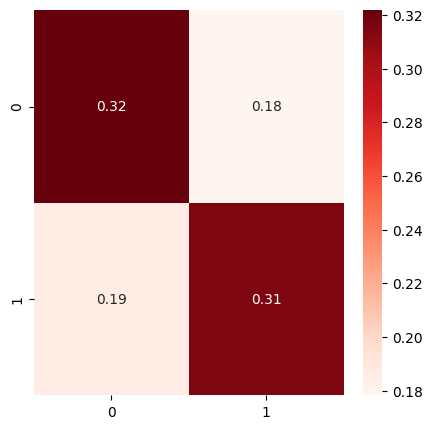

In [66]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [67]:
model = LGBMClassifier()

In [68]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [69]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [70]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-24 12:19:16,581] A new study created in memory with name: no-name-559e72b9-2151-4659-ac45-75b98d244b51


[12:19:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:18,682] Trial 0 finished with value: 0.5756823821339951 and parameters: {'learning_rate': 0.004827722594439593, 'max_depth': 257, 'n_estimators': 700, 'subsample': 0.7417012854596936, 'colsample_bylevel': 0.526537010567378, 'gamma': 1.2402551482541435}. Best is trial 0 with value: 0.5756823821339951.


[12:19:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:19,138] Trial 1 finished with value: 0.6202247191011236 and parameters: {'learning_rate': 0.0025836121233291133, 'max_depth': 284, 'n_estimators': 300, 'subsample': 0.26334823016775827, 'colsample_bylevel': 0.9066056600232544, 'gamma': 1.7691704986510188}. Best is trial 1 with value: 0.6202247191011236.


[12:19:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:19,526] Trial 2 finished with value: 0.5686746987951806 and parameters: {'learning_rate': 0.0308517749609848, 'max_depth': 119, 'n_estimators': 300, 'subsample': 0.21268018681149142, 'colsample_bylevel': 0.4588640043572546, 'gamma': 1.066286291813537}. Best is trial 1 with value: 0.6202247191011236.


[12:19:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:19,856] Trial 3 finished with value: 0.5480769230769231 and parameters: {'learning_rate': 0.0819766625161917, 'max_depth': 303, 'n_estimators': 100, 'subsample': 0.8806219450434024, 'colsample_bylevel': 0.4049660742770832, 'gamma': 0.9857776308806052}. Best is trial 1 with value: 0.6202247191011236.


[12:19:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:20,212] Trial 4 finished with value: 0.5287958115183247 and parameters: {'learning_rate': 0.0036132792561635154, 'max_depth': 256, 'n_estimators': 200, 'subsample': 0.7130275655277359, 'colsample_bylevel': 0.0998643876246571, 'gamma': 0.33386546007295054}. Best is trial 1 with value: 0.6202247191011236.


[12:19:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:21,135] Trial 5 finished with value: 0.5714285714285715 and parameters: {'learning_rate': 0.009219847340821196, 'max_depth': 241, 'n_estimators': 600, 'subsample': 0.24939058180961043, 'colsample_bylevel': 0.7149364792305059, 'gamma': 1.5738752844056774}. Best is trial 1 with value: 0.6202247191011236.


[12:19:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:21,556] Trial 6 finished with value: 0.5436893203883496 and parameters: {'learning_rate': 0.06959630538562761, 'max_depth': 351, 'n_estimators': 100, 'subsample': 0.9710339330618176, 'colsample_bylevel': 0.9368952823371686, 'gamma': 1.3636366633019934}. Best is trial 1 with value: 0.6202247191011236.


[12:19:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:23,645] Trial 7 finished with value: 0.5797101449275361 and parameters: {'learning_rate': 0.0017349963688347507, 'max_depth': 251, 'n_estimators': 800, 'subsample': 0.8223243958939775, 'colsample_bylevel': 0.32998254677167527, 'gamma': 2.9089168872992093}. Best is trial 1 with value: 0.6202247191011236.


[12:19:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:25,896] Trial 8 finished with value: 0.5680190930787589 and parameters: {'learning_rate': 0.05402985095145968, 'max_depth': 107, 'n_estimators': 900, 'subsample': 0.9611707216895913, 'colsample_bylevel': 0.1132137464915281, 'gamma': 2.6458061814179614}. Best is trial 1 with value: 0.6202247191011236.


[12:19:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:26,827] Trial 9 finished with value: 0.5397590361445783 and parameters: {'learning_rate': 0.06063764202375644, 'max_depth': 485, 'n_estimators': 700, 'subsample': 0.30043193383769273, 'colsample_bylevel': 0.304702685180607, 'gamma': 1.8048730366204737}. Best is trial 1 with value: 0.6202247191011236.


[12:19:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:27,129] Trial 10 finished with value: 0.6053811659192826 and parameters: {'learning_rate': 0.001268474596434024, 'max_depth': 408, 'n_estimators': 400, 'subsample': 0.07056029053897289, 'colsample_bylevel': 0.9928305752415174, 'gamma': 2.1614263141925525}. Best is trial 1 with value: 0.6202247191011236.


[12:19:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:27,436] Trial 11 finished with value: 0.6191536748329621 and parameters: {'learning_rate': 0.0011558935166919844, 'max_depth': 421, 'n_estimators': 400, 'subsample': 0.07503596319870379, 'colsample_bylevel': 0.9912712339646079, 'gamma': 2.2140263195280228}. Best is trial 1 with value: 0.6202247191011236.


[12:19:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:28,288] Trial 12 finished with value: 0.5976470588235294 and parameters: {'learning_rate': 0.0010166515534656586, 'max_depth': 459, 'n_estimators': 400, 'subsample': 0.4684943621731419, 'colsample_bylevel': 0.7783689995843471, 'gamma': 2.227715736406301}. Best is trial 1 with value: 0.6202247191011236.


[12:19:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:28,763] Trial 13 finished with value: 0.625287356321839 and parameters: {'learning_rate': 0.0029573538705494878, 'max_depth': 359, 'n_estimators': 500, 'subsample': 0.11319971531838231, 'colsample_bylevel': 0.8522254440600245, 'gamma': 2.112305037548869}. Best is trial 13 with value: 0.625287356321839.


[12:19:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:29,851] Trial 14 finished with value: 0.6047619047619047 and parameters: {'learning_rate': 0.0027465759057655604, 'max_depth': 185, 'n_estimators': 500, 'subsample': 0.4440956147301954, 'colsample_bylevel': 0.7809094029600444, 'gamma': 1.8352679804641021}. Best is trial 13 with value: 0.625287356321839.


[12:19:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:31,586] Trial 15 finished with value: 0.5748218527315915 and parameters: {'learning_rate': 0.009260298961411, 'max_depth': 345, 'n_estimators': 1000, 'subsample': 0.335090075853578, 'colsample_bylevel': 0.6553565505401726, 'gamma': 0.5863241356769159}. Best is trial 13 with value: 0.625287356321839.


[12:19:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:31,949] Trial 16 finished with value: 0.6241457858769932 and parameters: {'learning_rate': 0.005915277105637878, 'max_depth': 365, 'n_estimators': 300, 'subsample': 0.15930010959620639, 'colsample_bylevel': 0.8618191957388199, 'gamma': 2.46086511141468}. Best is trial 13 with value: 0.625287356321839.


[12:19:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:32,645] Trial 17 finished with value: 0.5957446808510638 and parameters: {'learning_rate': 0.016935832769979946, 'max_depth': 378, 'n_estimators': 600, 'subsample': 0.16538373566116765, 'colsample_bylevel': 0.5869143473774987, 'gamma': 2.5574737531201563}. Best is trial 13 with value: 0.625287356321839.


[12:19:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:34,038] Trial 18 finished with value: 0.5843230403800475 and parameters: {'learning_rate': 0.005895989719303466, 'max_depth': 332, 'n_estimators': 500, 'subsample': 0.5900963834904478, 'colsample_bylevel': 0.8531695098172937, 'gamma': 2.912297512707286}. Best is trial 13 with value: 0.625287356321839.


[12:19:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:34,720] Trial 19 finished with value: 0.5423728813559322 and parameters: {'learning_rate': 0.015411391434982507, 'max_depth': 407, 'n_estimators': 300, 'subsample': 0.3910251857013493, 'colsample_bylevel': 0.8256776770343779, 'gamma': 2.4825804844184765}. Best is trial 13 with value: 0.625287356321839.


[12:19:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:35,252] Trial 20 finished with value: 0.6084905660377359 and parameters: {'learning_rate': 0.006949179859799777, 'max_depth': 186, 'n_estimators': 200, 'subsample': 0.5718469064084338, 'colsample_bylevel': 0.6732640257568661, 'gamma': 2.0555156636491247}. Best is trial 13 with value: 0.625287356321839.


[12:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:35,584] Trial 21 finished with value: 0.6306306306306307 and parameters: {'learning_rate': 0.0021806009274343676, 'max_depth': 306, 'n_estimators': 300, 'subsample': 0.14547668309243483, 'colsample_bylevel': 0.8891899444741352, 'gamma': 1.7662622085998587}. Best is trial 21 with value: 0.6306306306306307.


[12:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:35,828] Trial 22 finished with value: 0.6347826086956522 and parameters: {'learning_rate': 0.0018704983882123, 'max_depth': 314, 'n_estimators': 200, 'subsample': 0.16244730637491736, 'colsample_bylevel': 0.8804032354994547, 'gamma': 2.3892842984522207}. Best is trial 22 with value: 0.6347826086956522.
[I 2024-11-24 12:19:35,979] Trial 23 finished with value: 0.6263982102908277 and parameters: {'learning_rate': 0.0022610968074612296, 'max_depth': 308, 'n_estimators': 200, 'subsample': 0.05578527328393871, 'colsample_bylevel': 0.7304772046022563, 'gamma': 1.5999336409145495}. Best is trial 22 with value: 0.6347826086956522.


[12:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:36,218] Trial 24 finished with value: 0.6271929824561403 and parameters: {'learning_rate': 0.0016509050192551752, 'max_depth': 313, 'n_estimators': 200, 'subsample': 0.16401407584508537, 'colsample_bylevel': 0.7366577151965538, 'gamma': 1.5162688983494046}. Best is trial 22 with value: 0.6347826086956522.
[I 2024-11-24 12:19:36,364] Trial 25 finished with value: 0.6258205689277899 and parameters: {'learning_rate': 0.00158378558908999, 'max_depth': 217, 'n_estimators': 100, 'subsample': 0.20613065734734112, 'colsample_bylevel': 0.5969801260617534, 'gamma': 0.7083236342179712}. Best is trial 22 with value: 0.6347826086956522.


[12:19:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:19:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:36,740] Trial 26 finished with value: 0.6078886310904872 and parameters: {'learning_rate': 0.0017805819080407629, 'max_depth': 292, 'n_estimators': 200, 'subsample': 0.3540908147596457, 'colsample_bylevel': 0.932041101717352, 'gamma': 1.4746483986109902}. Best is trial 22 with value: 0.6347826086956522.


[12:19:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:36,969] Trial 27 finished with value: 0.6157407407407407 and parameters: {'learning_rate': 0.0038643341934991187, 'max_depth': 328, 'n_estimators': 100, 'subsample': 0.42465429977368474, 'colsample_bylevel': 0.7788765217570186, 'gamma': 1.9415586239121725}. Best is trial 22 with value: 0.6347826086956522.


[12:19:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:37,187] Trial 28 finished with value: 0.6220302375809934 and parameters: {'learning_rate': 0.0019849260401723504, 'max_depth': 281, 'n_estimators': 200, 'subsample': 0.134766353092799, 'colsample_bylevel': 0.6487046869212474, 'gamma': 1.1628292750529072}. Best is trial 22 with value: 0.6347826086956522.


[12:19:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:19:38,293] Trial 29 finished with value: 0.60431654676259 and parameters: {'learning_rate': 0.004109494400691314, 'max_depth': 221, 'n_estimators': 400, 'subsample': 0.6846516243202818, 'colsample_bylevel': 0.5513425138865534, 'gamma': 1.3660838308298162}. Best is trial 22 with value: 0.6347826086956522.


In [71]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.0018704983882123, 'max_depth': 314, 'n_estimators': 200, 'subsample': 0.16244730637491736, 'colsample_bylevel': 0.8804032354994547, 'gamma': 2.3892842984522207}
Best f1 score: 0.6347826086956522


In [72]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.0018704983882123, max_depth=314,
               n_estimators=200, random_seed=42, subsample=0.16244730637491736)

In [73]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.11988282, 0.11867762, 0.12612844, 0.12717962, 0.1251514 ]),
 'score_time': array([0.00972772, 0.00955963, 0.00934315, 0.00954938, 0.00946593]),
 'test_accuracy': array([0.70023981, 0.7146283 , 0.71153846, 0.70192308, 0.71634615]),
 'test_precision_macro': array([0.70457964, 0.75685275, 0.7716624 , 0.75286317, 0.73457891]),
 'test_recall_macro': array([0.56358111, 0.57982702, 0.56947388, 0.55487534, 0.58606075]),
 'test_f1_macro': array([0.53619255, 0.55845531, 0.54007739, 0.51560681, 0.57125389]),
 'test_roc_auc': array([0.86237079, 0.8885902 , 0.88230908, 0.89273474, 0.8698166 ])}

In [74]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       216
           1       0.00      0.00      0.00       216

    accuracy                           0.50       432
   macro avg       0.25      0.50      0.33       432
weighted avg       0.25      0.50      0.33       432

F2-score:  0.0


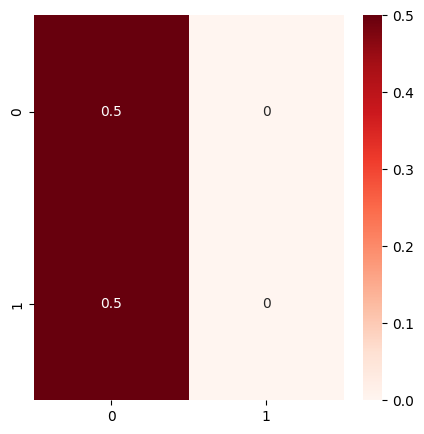

In [75]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [76]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [77]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [78]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [79]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.81 +- 0.02 , 'AUC': 0.87 +- 0.01 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.77 +- 0.02 ,'F1-score': 0.77 +- 0.02 ,'F2-score': 0.77 +- 0.02
'Accuracy': 0.82 +- 0.01 , 'AUC': 0.88 +- 0.01 ,'Precision': 0.8 +- 0.01 ,'Recall': 0.81 +- 0.01 ,'F1-score': 0.8 +- 0.01 ,'F2-score': 0.81 +- 0.01
'Accuracy': 0.82 +- 0.01 , 'AUC': 0.89 +- 0.01 ,'Precision': 0.8 +- 0.01 ,'Recall': 0.79 +- 0.01 ,'F1-score': 0.79 +- 0.01 ,'F2-score': 0.79 +- 0.01
'Accuracy': 0.71 +- 0.01 , 'AUC': 0.88 +- 0.01 ,'Precision': 0.74 +- 0.02 ,'Recall': 0.57 +- 0.01 ,'F1-score': 0.54 +- 0.02 ,'F2-score': 0.6 +- 0.01
'Accuracy': 0.82 +- 0.01 , 'AUC': 0.89 +- 0.02 ,'Precision': 0.8 +- 0.01 ,'Recall': 0.81 +- 0.01 ,'F1-score': 0.81 +- 0.01 ,'F2-score': 0.81 +- 0.01


In [80]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_val_imp, y_val))
  else: print(test_results(model, x_val_selected, y_val))

{'Accuracy': 0.82, 'AUC': 0.76, 'Precision': 0.73, 'Recall': 0.61, 'F1-score': 0.66, 'F2-score': 0.63}
{'Accuracy': 0.85, 'AUC': 0.85, 'Precision': 0.69, 'Recall': 0.85, 'F1-score': 0.76, 'F2-score': 0.81}
{'Accuracy': 0.83, 'AUC': 0.8, 'Precision': 0.7, 'Recall': 0.74, 'F1-score': 0.72, 'F2-score': 0.73}
{'Accuracy': 0.72, 'AUC': 0.53, 'Precision': 0.69, 'Recall': 0.08, 'F1-score': 0.15, 'F2-score': 0.1}
{'Accuracy': 0.86, 'AUC': 0.86, 'Precision': 0.73, 'Recall': 0.84, 'F1-score': 0.78, 'F2-score': 0.82}


In [81]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.7, 'Recall': 0.3, 'F1-score': 0.42, 'F2-score': 0.34}
{'Accuracy': 0.58, 'AUC': 0.58, 'Precision': 0.56, 'Recall': 0.72, 'F1-score': 0.63, 'F2-score': 0.68}
{'Accuracy': 0.64, 'AUC': 0.64, 'Precision': 0.64, 'Recall': 0.63, 'F1-score': 0.63, 'F2-score': 0.63}
{'Accuracy': 0.5, 'AUC': 0.5, 'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'F2-score': 0.0}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.59, 'Recall': 0.67, 'F1-score': 0.63, 'F2-score': 0.65}


In [82]:
import shap
shap.initjs()

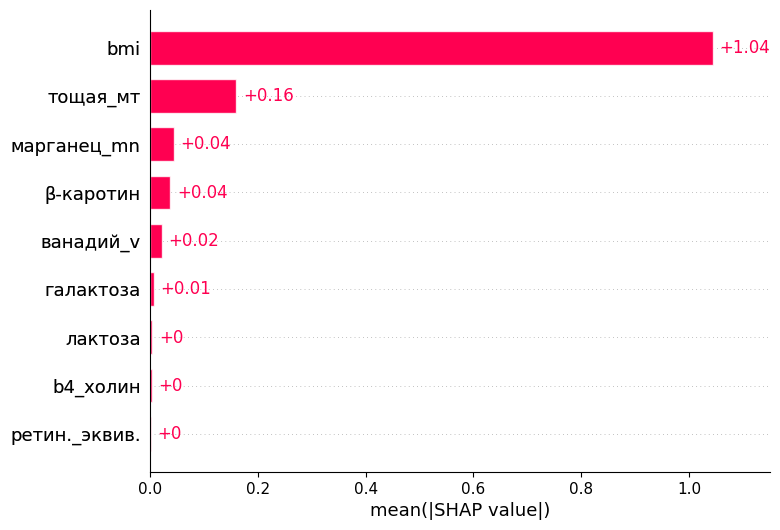

In [83]:
explainer = shap.TreeExplainer(xgb_rfc_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)

In [84]:
file_names = ["RFClassifier.txt","XGBRFClassifier.txt","XGBoostClassifier.txt","LightGBMClassifier.txt","CatBoostClassifier.txt"]
for i in range(len(best_models)):
    file = open(file_names[i], "w")
    file.write(str(best_models[i].feature_importances_))
    file.close()